#Topics covered

**Neuroscience**:

  * Gabor wavelets,
  * visual receptive fields
  * simple/compex cells (Hubel & Wiesel experiment),
  * tuning curve
  * LNP models
  * convolutional models
  
**Python**:

  * numpy.mgrid/ogrid
  * matplotlib: imshow, contour plots, bar plots
  * scopes, closures
  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In 1952 Hubel and Wiesel made an interesting discovery. When they inserted thin electrodes into cat's visual cortex and presented small spots of light on a screen in front of the cat, some of the cells responded by firing spikes only when the spot was at a particular positions. The same cell would be inhibited by spots located in different areas of visual field or it would not respond at all. The responses of such neurons were fully characterised by the inhibitory and excitatory areas in the visual field. They called such neurons **simple cells**.

They also found another type of cells that manifested more complex responses. These cells, called **complex cells**, would respond only to a visual object of a particular shape and orientation no matter where it was positioned in the visual field. If the image was slightly rotated or its shape was changed, the response was supressed.

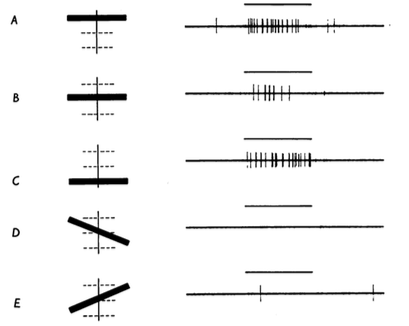

In [2]:
from IPython.display import Image
Image('images/hubel_wiesel_1962_fig7.png')

#Receptive fields

Receptive field is the set of the stimuli that evoke responses in single neurons. In case of visual receptive fields these are patches of ligth impaling on retina that are most effecitve in driving a neuron.  It is customary to represent visual receptive field as images showing the preffered stimuli.

We will now generate a sample receptive field using numpy. We start with a periodic pattern of light and dark regions along one axis. To represent it as an image we need a two-dimensional grid of $x$ and $y$ coordinates &mdash; one pair per pixel &mdash; which we store in two numpy arrays `XX` and `YY` each containing only one of the coordinates. This is best illustrated by the following schematics:

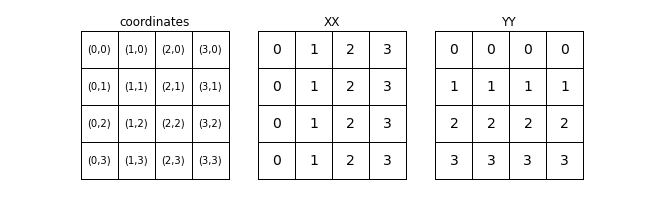

In [3]:
Image('images/meshgrid.png')

Note that the values in `XX` and `YY` arrays change only along columns and rows separately. We can generate these arrays using `mgrid` of `numpy`. When slice-indexed like a standard `numpy` array it returns appropriately formatted arrays. For example to obtain a two-dimensional grid in which each dimension goes from -20 to 20 every 0.04 we use:

In [9]:
xmin, xmax, dx = -20, 20, 0.04 #degree
ymin, ymax, dy = -20, 20, 0.04

YY, XX = np.mgrid[xmin:xmax:dx, ymin:ymax:dy]

Now we can generate a sine pattern along the `x` dimension:

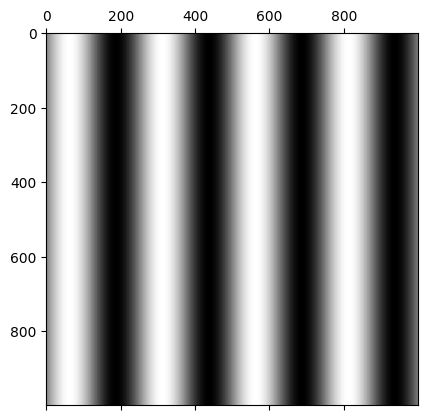

In [15]:
spatial_freq = 0.1
rf = np.sin(2 * np.pi * spatial_freq * XX)
plt.matshow(rf)
plt.gray()

In order to rotate the pattern by a given angle, we can transform the coordinates using the known expression for $x$ and $y$ in a rotated coordinate system:

$$\begin{align}x_r &= x\cos(\theta)+y\sin(\theta)\\ 
y_r &= -x\sin(\theta)+y\cos(\theta)
\end{align}$$

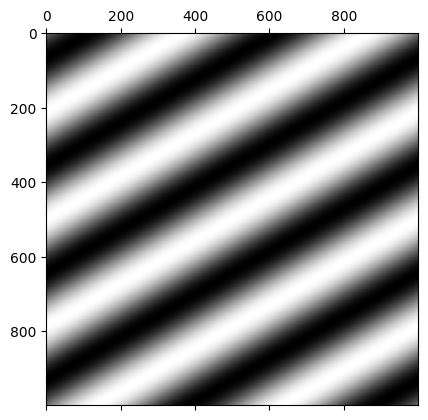

In [24]:
rf_angle = np.pi/3.

x_r = XX * np.cos(rf_angle) + YY * np.sin(rf_angle)
y_r = -XX * np.sin(rf_angle) + YY * np.cos(rf_angle)

rf = np.cos(2 * np.pi * spatial_freq * x_r)
plt.matshow(rf)
plt.gray()

To make the receptive field spatially-limited we mask it with a gaussian along the stripes and with a rectangle across the stripes:

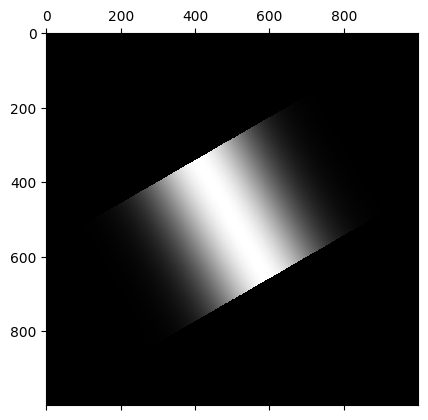

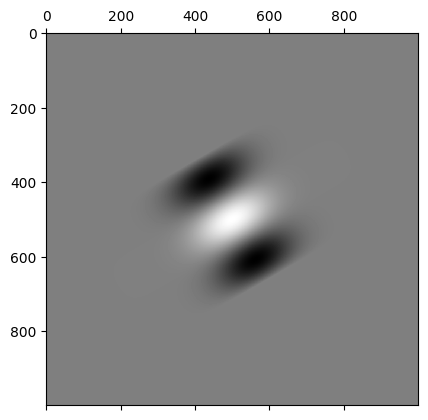

In [33]:
rf_height = 6.
rf_width = 7.5

mask_x = (np.abs(x_r) < rf_width)
mask_y = np.exp(-(y_r**2/rf_height**2))

plt.matshow(mask_y*mask_x)

rf *= mask_x * mask_y

plt.matshow(rf)

Since we are going to generate the receptive field quite often, we can define it in a function:

In [34]:
def receptive_field(XX, YY, theta, width, height):
    x_r = XX * np.cos(theta) + YY * np.sin(theta)
    y_r = -XX * np.sin(theta) + YY * np.cos(theta)
    gaussian = np.exp(-np.pi*(y_r**2/height**2)) * (np.abs(x_r) < width)
    F = 1./width * 0.75
    complex_grating = np.exp(1j*2*np.pi*F*x_r)
    return gaussian * complex_grating.real

In [35]:
rf_height = 10
rf_width = 4
rf_angle = 0.
rf_ampl = 1. #Hz

W = rf_ampl * receptive_field(XX, YY, rf_angle, rf_width, rf_height)

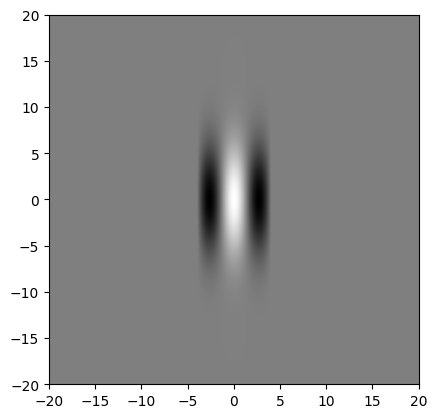

In [37]:
plt.imshow(W, extent=(xmin, xmax, xmin, xmax), aspect='equal')

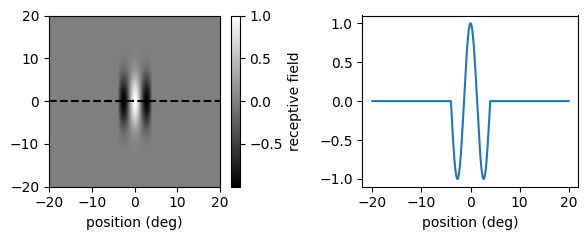

In [78]:
plt.figure(figsize=(6,2.5))

plt.subplot(121)
plt.imshow(W, extent=(xmin, xmax, xmin, xmax), aspect='equal')
plt.xlabel('position (deg)')
plt.axhline(0, ls='--', color='k')
plt.gray()
cbar = plt.colorbar()

plt.subplot(122)
plt.plot(XX[500,:], W[500, :])
plt.xlabel('position (deg)')
cbar.set_label('receptive field')
plt.tight_layout()

A cross-section (dashed line) through the middle of receptive fields shows excitatory (positive) center with inhibitory (negative) flank. Such a receptive field is typical of neurons in primary visual cortex of cats.

#Simple cell

We will now analyse a response of a simple cell with a receptive field generated in the previous section to a white bar on the black background. We can generate the visual stimulus the same way we generated the receptive field:

In [80]:
def bar(XX, YY, length, width, angle):    
    x_r = XX * np.cos(angle) + YY * np.sin(angle)
    y_r = -XX * np.sin(angle) + YY * np.cos(angle)
    return  1 * (np.abs(x_r) < length / 2) * (np.abs(y_r) < width / 2)

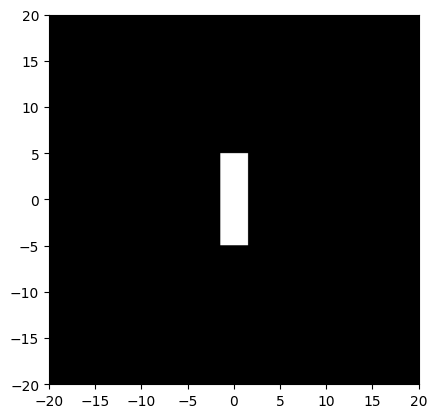

In [81]:
bar_length = 10.
bar_width = 3.
bar_angle = np.pi/2.
bar_lumosity = 1 
b = bar(XX, YY, bar_length, bar_width, bar_angle)
plt.imshow(b, extent=(xmin, xmax, ymin, ymax))
plt.gray()

The response of a single cell is proportional to the scalar product of the receptive field $RF_{ij}$ with the stimulus $S_{ij}$ or in other words the sum over the pixel product of both images:

$$r_\mathrm{simple}=\left[\sum_i^{N_x}\sum_j^{N_y}S_{ij}RF_{ij}\Delta x\Delta y + r_\mathrm{baseline}\right]_+$$

Half-way rectification, denoted by square brackets with a "+" subscript (such that $[x]_+=\max(0,x)$), was introduced to keep the firing rate of a simple cell strictly positive.

Since a neuron can not produce negative firing rates, to represent inhibition we introduce a baseline firing rate $r_\mathrm{baseline}$: a firing rate above the baseline represents excitation, while a firing rate below the baseline means inhibition. 

We are going to implement models of different cell types (complex and simple), which will always take the visual stimulus (a two-dimensional `numpy` array) as their inputs and produce a firing rate response (a scalar) in their outputs. However, these models differ in the way how the output is calculated from the inputs. To make these models usable in similar context we are going to separate these implementation details (the receptive field and how it is used to compute the output) from the interface (the inputs and outputs). This is one of the main software engineering concepts called **abstraction**.

Python offers several ways to obtain this abstraction, one of them being **closures**. A closure is a function with some external state. It is implemented by means of a **nested function** (function defined within a function). Each function defines its own **scope** (a code block in which define variables are accessible), but has also an access of the variables in the scope of the function higher up in the nesting hierarchy. We will use this scope to store (static) state variables for the nested function.

Here is the implementation:

In [13]:
def rectify(x):
    return x * (x > 0)

def simple_cell_model(receptive_field, baseline_rate, dxy):
    dx, dy = dxy
    def _response(stim):
        r = np.sum(stim * receptive_field) * dx * dy + baseline_rate
        return rectify(r)
    return _response

**Comments**:

* **L4**: the wrapping function takes two arguments we will later use to calculate the response of a simple cell. These two arguments define the state  of the cell.

* **L6-8**: definition of the nested function. This function takes an extra argument, the visual stimulus, but it has also an access to the `receptive_field` and `baseline_rate` variables of the enclosing function.

* **L9**: the enclosing function returns the nested function. In Python functions are "first-class citizens" which means that they can be assigned to variables, returned etc. like any other object. Note that the returned function will keep the variables in the scope of enclosing function (`receptive_field` and `baseline_rate`), even after the function is finished.

To define a new cell we call the above function with two arguments, the receptive field (two-dimensional array) and the baseline firing rate:

In [14]:
baseline_rate = 20
simple_cell = simple_cell_model(W, 20, (dx, dy)) 

We can now calculate the response to the bar stimulus we defined previously:

In [15]:
r = simple_cell(b)
print("Output firing rate: {:.1f} Hz".format(r))
print("Change from baseline: {:.1f} Hz".format(r - baseline_rate))

Output firing rate: 33.1 Hz
Change from baseline: 13.1 Hz


Let us now look at the responses of this simple cell to two bar shifted with respect to each other in `x` coordinate:

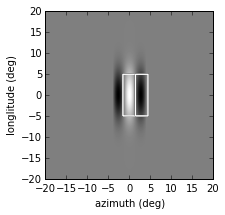

In [16]:
plt.figure(figsize=(3, 3))
plt.imshow(W, extent=(xmin, xmax, ymin, ymax))
b1 = bar(XX, YY, bar_length, bar_width, bar_angle)
b2 = bar(XX - bar_width, YY, bar_length, bar_width, bar_angle)
plt.contour(XX[0,:], YY[:,0], b1)
plt.contour(XX[0,:], YY[:,0], b2)
plt.xlabel('azimuth (deg)')
plt.ylabel('longlitude (deg)')

The two bars are superimposed on the receptive field using white lines. In order to plot them we used `contour` plot from `matplotlib` library, which shows contour lines of constant levels in a two dimensional map.

Let us compare the responses of this simple neuron to presentations of each of the bar separately (Bar 1 and 2), sum of the responses, and the response to both bars presented together (Bar 1+2). Since we are only interested in change from the baseline firing rate, we first subtract the baseline.

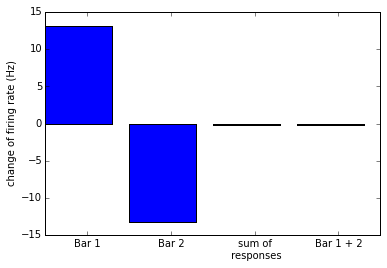

In [17]:
r1 = simple_cell(b1) - baseline_rate
r2 = simple_cell(b2) - baseline_rate
r1and2 = simple_cell(b1 + b2) - baseline_rate
plt.bar(range(4), [r1, r2, r1+r2, r1and2])
plt.xticks(np.arange(4) + 0.5, ["Bar 1", "Bar 2", "sum of\n responses", "Bar 1 + 2"])
plt.ylabel('change of firing rate (Hz)')

Bar 1 impinged on excitatory part of the receptive field, so it produced an increase in the firing rate. Bar 2 appeared on the inhibitory part of the receptive field, so it produced a decrease of the firing rate. Responses to these bars counteracted each other, so when the responses were summed together there was no net change in the total firing rate. Imporatantly, when the bars were presented simultaneously the response was equal to the one obtained by summing responses to individual bars. This is a consequence of a linearity of a simple cell: a response to a visual stimulus is equal to the sum of responses to its parts. This fact was used by Hubel an Wiesel to map receptive field of simple cells by means of responses to small dots of light.

# Position and orientation tuning

Another way to characterise responses of neurons in visual cortex to a set of stimuli is to construct so called **tuning curves**. A tuning curve describes responses of a neuron to smooth variation of a single parameter characterising the stimulus, such as its position along one of the axes, it angle or size.

Let us start with an orientation tuning, which summarizes responses to a change of stimulus angle. We define a function which takes a function calculating the firing rate for the given stimulus  as it only argument. For the stimulus we re-use the bar we defined previously and vary its angle.

In [18]:
def orientation_tuning(response_func):
    responses = []
    thetas = np.linspace(-np.pi, np.pi, 100)
    for theta in thetas:
        b = bar(XX, YY, bar_length, bar_width, theta)
        r = response_func(b)
        responses.append(r)
    responses = np.array(responses)
    return thetas, responses

The response of a single cell to bars of varying orientation is periodic with a maximum for vertically-oriented bars ($\theta=k\pi/2$ for $k=1,2,...$):

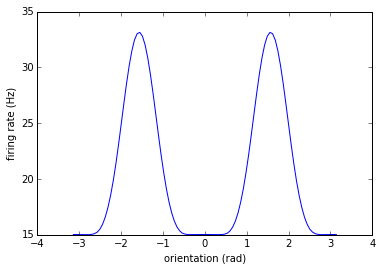

In [19]:
thetas, responses = orientation_tuning(simple_cell)
plt.plot(thetas, responses)
plt.xlabel('orientation (rad)')
plt.ylabel('firing rate (Hz)')

Similarly, we can analyse the change of firing rate to variation of the bar's position, so called **orientation tuning**. 

In [20]:
def position_tuning(response_func):
    xcoords = np.linspace(-10, 10, 100)
    responses = []
    for x0 in xcoords:
        b = bar(XX - x0, YY, bar_length, bar_width, bar_angle)
        r = response_func(b)
        responses.append(r)
    responses = np.array(responses)
    return xcoords, responses

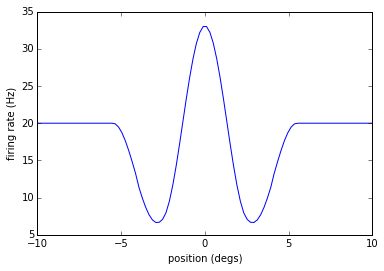

In [21]:
xcoords, responses = position_tuning(simple_cell)
plt.plot(xcoords, responses)
plt.xlabel('position (degs)')
plt.ylabel('firing rate (Hz)')

#Complex cell

Now we turn to modelling the complex cell. As I already mentioned complex cells respond to an object of particular size and shape regardless from where it is excatly located within its receptive field. In technical terms this is call **translation invariance**. 

Hubel and Wiesel proposed that this invariance could arise by summing responses from multiple simple cells with translated receptive fields, as illustrated in this figure from their orignal 1962 paper (Fig.20):

![Image Alt](images/hubel_wiesel_1962_fig20.png)

We first define a function to calculate the response of a complex cell to a given stimulus. Again we are going to use a closure. The wrapping function takes a single argumemt, which is a list of simple cells. The nested function simply iterates over all of these cells and sums up their responses:

In [22]:
def complex_cell_model(simple_cells):    
    def _response(stim):
        response = 0
        for inp in simple_cells:
            response += (inp(stim))
        return response 
    return _response

To construct a new complex cell, first we define a list of simple cells, which all have the same receptive field shape, but translated with respect to each other:

In [23]:
x_rf = np.arange(-8, 8, 1) #linspace(-8, 8, 17)
Ws = [receptive_field(XX - x0, YY, rf_angle, rf_width, rf_height) for x0 in x_rf]
simple_cells = [simple_cell_model(rf, 0, (dx, dy)) for rf in Ws]

We can plot the receptive fields using contour plots for excitatory (red) and inhibitory (blue) domains:

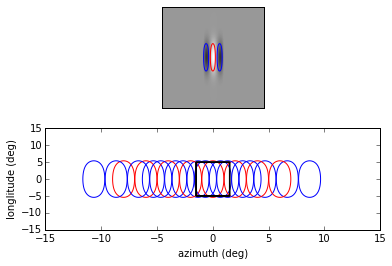

In [24]:
plt.subplot(211)
plt.imshow(W, extent=(xmin, xmax, ymin, ymax), alpha=0.8)
plt.xticks([])
plt.yticks([])
plt.gray()
plt.contour(XX[0,:], YY[:,0], W, [-0.4, 0.4], colors=['b', 'r'])

plt.subplot(212)
for w in Ws[::2]:
    plt.contour(XX[0, :], YY[:, 0], w, [-0.4, 0.4], colors=['b', 'r'])
plt.ylim([-15, 15])
plt.xlim([-15, 15])
plt.xlabel('azimuth (deg)')
plt.ylabel('longlitude (deg)')
plt.contour(XX[0,:], YY[:,0], b1, colors=['k'])

As you can see the inhibitory and excitatory domains in receptive fields of different neurons overlap each other (for size comparison, I added a sample bar in black). This is required to obtain the translation invariance. Let us now simulate a complex cell summing responses from so-defined simple cells and plot its position tuning:

In [25]:
complex_cell = complex_cell_model(simple_cells)

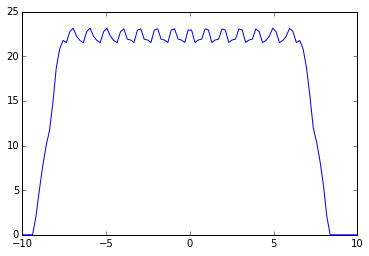

In [26]:
xcoords, responses = position_tuning(complex_cell)
plt.plot(xcoords, responses)

Note that the response is high wherever the bar is located within the receptive field and falls off only at the flanks of the receptive field.

The orientation tuning is very similar to the one of a simple cell including the maxima at the multiples of $\pi/2$:

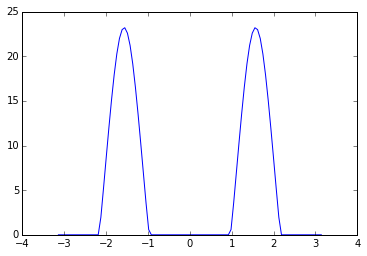

In [27]:
thetas, responses = orientation_tuning(complex_cell)
plt.plot(thetas, responses)

An interesting property of a complex cell is that a response to a sum of two bars is not necessarily a sum of responses to a single bar. Let us take the stimuli in the form of two bars that  we defined earlier to characterise the responses of a simple cell.

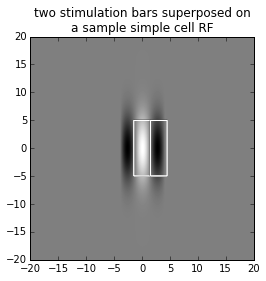

In [28]:
plt.imshow(W, extent=(xmin, xmax, ymin, ymax))
plt.contour(XX[0,:], YY[:,0], b1)
plt.contour(XX[0,:], YY[:,0], b2)
plt.title('two stimulation bars superposed on\na sample simple cell RF')

 When one part of the bar falls upon an excitatory domain and the other on the inhibitory domain of a simple cell, its response may not change ("Bar 1 + 2" below). However, when we present the bars separately, each may activate a different simple cell proividing input to the complex cell, so that the total response will be a sum of response of these simple cell ("Sum of responses" column). This behaviour is only possible due to the rectifying nonlinearity in the output of the simple cell and can note be produced by a linear model.

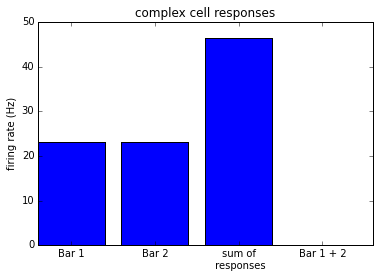

In [29]:
r1 = complex_cell(b1)
r2 = complex_cell(b2)
r1and2 = complex_cell(b1 + b2)
plt.bar(range(4), [r1, r2, r1+r2, r1and2])
plt.xticks(np.arange(4) + 0.4, ["Bar 1", "Bar 2", "sum of\n responses", "Bar 1 + 2"])
plt.ylabel('firing rate (Hz)')
plt.title('complex cell responses')

# Retinotopy

In the complex cell example we looked at the situation where simple cells with translated receptive fields cover an area of a visual field. In fact, it is a common architectural feature of the cortex: the same type of responses is laid out over a larger sensory area. In the visual cortex such a mapping is called the **retinotopy**, in the somatosensory cortex (encoding skin senses such as touch and pain) it is called **somatotopy**, and in the audtiory cortex, where the sensory space is the dominant frequency of auditory signal, the **tonotopy**.

Each position in the map is represented by a single cell or a group of cells with a receptive field centered at the position. We can illustrate this idea using a simple example: In the figure below the map is shown as a grid and each image in the grid represents a receptive field of a cell at the corresponding location within the map.

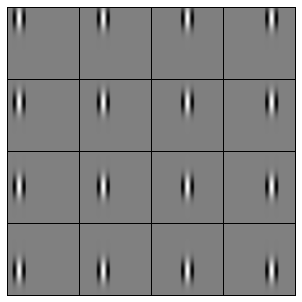

In [30]:
plt.figure(figsize=(6,6))
n_grid = 4
fig, axes = plt.subplots(n_grid,n_grid, 
                         figsize=(4,4),
                         gridspec_kw=dict(hspace=0,
                                          wspace=0,
                                          left=0,
                                          right=1,
                                          bottom=0,
                                          top=1))
delta_x0 = (xmax - xmin)/(n_grid + 2)
delta_y0 = (ymax - ymin)/(n_grid + 2)

for i in range(n_grid):
    for j in range(n_grid):
        ax = axes[j, i]
        x0, y0 = xmax - (i+1) * delta_x0, ymax - (j + 1) * delta_y0
        rf = receptive_field(XX + x0, YY + y0 , rf_angle, rf_width, rf_height)
        ax.imshow(rf)
        ax.set_xticks([])
        ax.set_yticks([])

Mathematically, multiplication of an input image with each of the above receptive fields to get a map of responses, is equivalent to a two-dimensional convolusion. The limitation is that at each position the receptive field must be identical, but in return it offers much computational advantage.

As an example, we will calculate a map of responses of simple cells to this image:

In [31]:
R = 3
dR = 1
XX, YY = np.ogrid[-20:20:800j,-20:20:800j]
r = np.sqrt(XX**2+YY**2)
im = (((r % R) > 0) * ((r % R) < dR)).astype('u1')

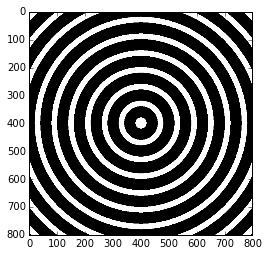

In [32]:
plt.imshow(im)
plt.gray()

Due to computational resasons, we will reduce the size (downsample) of receptive field used before and adjust the receptive field size to the spatial frequencies in the image:

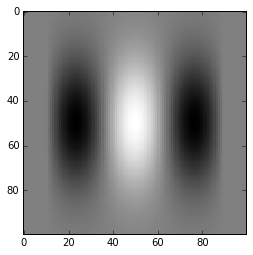

In [33]:
YY_ds, XX_ds = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
rf_width_ds = rf_width * 4
rf_height_ds = rf_height * 2
W_ds = rf_ampl * receptive_field(XX_ds, YY_ds, rf_angle, rf_width_ds, rf_height_ds)
plt.imshow(W_ds, interpolation='nearest')
plt.gray()

The two-dimensional convolution is implemented in `signal` module of `scipy` package:

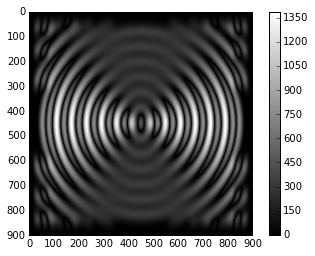

In [34]:
from scipy import signal
def simple_cell_map(im, W):
    conv = signal.convolve2d(im, W)
    map_response = rectify(conv) + rectify(-conv)
    return map_response
map_response = simple_cell_map(im, W_ds)
plt.imshow(map_response)
plt.colorbar()

Similarly to the simple cell response we used the `rectify` function to ensure positive firing rates. In addtition we summed the response with the response of a simple cell with a negative receptive field. This little trick allows us to make the map of orientation of image features, irrespective of their brightness ("white on black background" or "black on white background").

We can now combine the responses to the receptive fields at angles of 0, $\frac{\pi}{4}$, $\frac{\pi}{2}$ and $\frac{3\pi}{4}$ using vector summation:

$$\phi(x,y)=\sum_{\theta}r_{\theta}(x,y)e^{2i\theta},$$

where $r_{\theta}$ is the response of a cell with a receptive field oriented at angle $\theta$.

In [35]:
phi = 0
thetas = np.linspace(0, np.pi, 4)[:-1]
for theta in thetas:
    W_ds = receptive_field(XX_ds, YY_ds, theta, rf_width_ds, rf_height_ds)
    c = simple_cell_map(im, W_ds)
    phi = phi + c * np.exp(2j*theta)

We take the angle of the vector in complex plane as the estimated local orientation in the image:

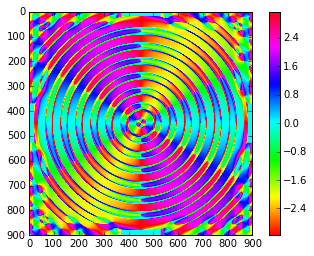

In [36]:
angles = np.angle(phi)
plt.imshow(angles)
plt.hsv()
plt.colorbar()